In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

Загрузим датасеты - отдельно для обучения и теста

In [3]:
%%time
reviews_train = load_files("aclImdb/train/")
text_train, y_train = reviews_train.data, reviews_train.target

CPU times: user 1.54 s, sys: 3.4 s, total: 4.94 s
Wall time: 9.53 s


In [93]:
print("Число отзывов для обучения: %d" % len(text_train))
print(np.bincount(y_train))

Число отзывов для обучения: 1434
[717 717]


In [5]:
%%time
reviews_test = load_files("aclImdb/test/")
text_test, y_test = reviews_test.data, reviews_test.target

CPU times: user 1.56 s, sys: 4.09 s, total: 5.65 s
Wall time: 10.9 s


In [92]:
print("Число отзывов для валидации: %d" % len(text_test))
print(np.bincount(y_test))

Число отзывов для валидации: 1434
[717 717]


Мы видим, что число классов сбалансировано, поэтому для оценки правильности предсказания будет достаточно подсчитать сколько раз предсказался тот или иной класс

### Примеры текстов

In [94]:
print(text_train[10])

b'\xd0\xa2\xd0\xb0\xd1\x80\xd0\xb0\xd0\xb7. 26 \xd0\xbd\xd0\xbe\xd1\x8f\xd0\xb1\xd1\x80\xd1\x8f. Kazakhstan Today - \xd0\x92 \xd0\x96\xd0\xb0\xd0\xbc\xd0\xb1\xd1\x8b\xd0\xbb\xd1\x81\xd0\xba\xd0\xbe\xd0\xb9 \xd0\xbe\xd0\xb1\xd0\xbb\xd0\xb0\xd1\x81\xd1\x82\xd0\xb8 \xd0\xbf\xd0\xbe\xd0\xb4\xd0\xbf\xd0\xb8\xd1\x81\xd0\xb0\xd0\xbd\xd0\xbe 12 \xd0\xbc\xd0\xb5\xd0\xbc\xd0\xbe\xd1\x80\xd0\xb0\xd0\xbd\xd0\xb4\xd1\x83\xd0\xbc\xd0\xbe\xd0\xb2 \xd0\xbd\xd0\xb0 120 \xd0\xbc\xd0\xbb\xd1\x80\xd0\xb4 \xd1\x82\xd0\xb5\xd0\xbd\xd0\xb3\xd0\xb5 \xd0\xb2 \xd1\x85\xd0\xbe\xd0\xb4\xd0\xb5 \xd0\x9c\xd0\xb5\xd0\xb6\xd0\xb4\xd1\x83\xd0\xbd\xd0\xb0\xd1\x80\xd0\xbe\xd0\xb4\xd0\xbd\xd0\xbe\xd0\xb3\xd0\xbe \xd0\xb8\xd0\xbd\xd0\xb2\xd0\xb5\xd1\x81\xd1\x82\xd0\xb8\xd1\x86\xd0\xb8\xd0\xbe\xd0\xbd\xd0\xbd\xd0\xbe\xd0\xb3\xd0\xbe \xd1\x84\xd0\xbe\xd1\x80\xd1\x83\xd0\xbc\xd0\xb0 "Taraz Invest - AgroChemical Day 2016", \xd1\x81\xd0\xbe\xd0\xbe\xd0\xb1\xd1\x89\xd0\xb8\xd0\xbb\xd0\xb8 \xd0\xb2 \xd0\xb0\xd0\xba\xd0\xb8\xd0\x

In [23]:
print(text_train[5])

b"The Movie was sub-par, but this Television Pilot delivers a great springboard into what has become a Sci-Fi fans Ideal program. The Actors deliver and the special effects (for a television series) are spectacular. Having an intelligent interesting script doesn't hurt either.<br /><br />Stargate SG1 is currently one of my favorite programs."


Преобразуем слова в признаки - для этого нужно составить словарь слов

In [95]:
cv = CountVectorizer()
cv.fit(text_train)

len(cv.vocabulary_)

62409

In [96]:
X_train = cv.transform(text_train)
X_train

<1434x62409 sparse matrix of type '<class 'numpy.int64'>'
	with 398736 stored elements in Compressed Sparse Row format>

In [10]:
print(text_train[19726])

b'This movie is terrible but it has some good effects.'


In [11]:
X_train[19726].nonzero()

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32),
 array([ 9881, 21020, 28068, 29999, 34585, 34683, 44147, 61617, 66150,
        66562], dtype=int32))

In [97]:
X_test = cv.transform(text_test)

Обучим классификатор - логистическая регрессия

In [103]:
%%time
logit = LogisticRegression(n_jobs=-1, random_state=7)
logit.fit(X_train, y_train)

CPU times: user 704 ms, sys: 23 ms, total: 727 ms
Wall time: 741 ms


In [104]:
round(logit.score(X_train, y_train), 3), round(logit.score(X_test, y_test), 3)

(1.0, 0.888)

In [18]:
def visualize_coefficients(classifier, feature_names, n_top_features=25):
    # get coefficients with large absolute values 
    coef = classifier.coef_.ravel()
    positive_coefficients = np.argsort(coef)[-n_top_features:]
    negative_coefficients = np.argsort(coef)[:n_top_features]
    interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])
    # plot them
    plt.figure(figsize=(15, 5))
    colors = ["red" if c < 0 else "green" for c in coef[interesting_coefficients]]
    plt.bar(np.arange(2 * n_top_features), coef[interesting_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * n_top_features), feature_names[interesting_coefficients], rotation=60, ha="right");

    
def plot_grid_scores(grid, param_name):
    plt.plot(grid.param_grid[param_name], grid.cv_results_['mean_train_score'],
        color='green', label='train')
    plt.plot(grid.param_grid[param_name], grid.cv_results_['mean_test_score'],
        color='red', label='test')
    plt.legend();

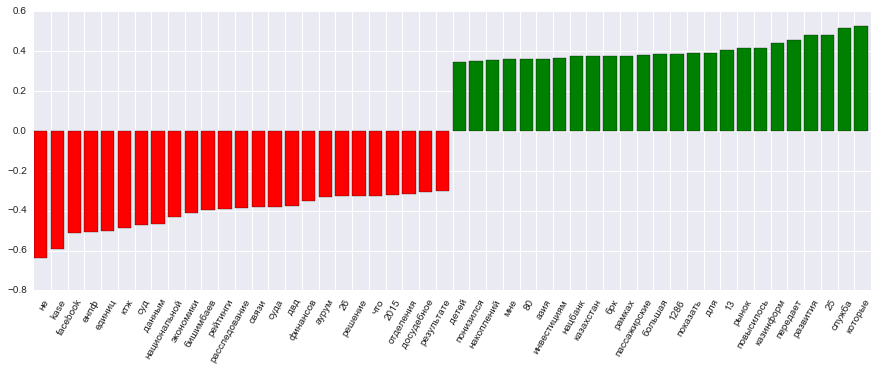

In [101]:
visualize_coefficients(logit, cv.get_feature_names())

Задание: загрузите датасет по новостям и проведите классификацию

In [25]:
import json
import pandas as pd

In [28]:
with open('all/train.json') as f:
    data = pd.DataFrame(json.load(f))

data[data.sentiment.isin(['negative','positive'])]

train_set = data[data.sentiment.isin(['negative','positive'])]['text'].tolist()
for i, x in enumerate(train_set):
    with open('news_dataset/train/{}_news.txt'.format(i), 'w') as f:
        f.write(x)

In [64]:
neg = data[data.sentiment.isin(['negative'])]['text'].tolist()

In [68]:
pos = data[data.sentiment.isin(['positive'])]['text'].tolist()

In [83]:
for i, x in enumerate(neg[:len(neg)//2]):
    with open('news_dataset/train/neg/{}_neg_news_train.txt'.format(i), 'w') as f:
        f.write(x)
        
for i, x in enumerate(neg[len(neg)//2:]):
    with open('news_dataset/test/neg/{}_neg_news_test.txt'.format(i), 'w') as f:
        f.write(x)

In [ ]:
for i, x in enumerate(pos[:len(neg)//2]):
    with open('news_dataset/train/pos/{}_pos_news_train.txt'.format(i), 'w') as f:
        f.write(x)

In [89]:
for i, x in enumerate(pos[len(neg)//2:1434]):
    with open('news_dataset/test/pos/{}_pos_news_test.txt'.format(i), 'w') as f:
        f.write(x)

In [85]:
%%time
reviews_train = load_files("news_dataset/train")
text_train, y_train = reviews_train.data, reviews_train.target

CPU times: user 97.4 ms, sys: 193 ms, total: 290 ms
Wall time: 561 ms


In [86]:
y_train.shape

(1434,)

In [90]:
%%time
reviews_test = load_files("news_dataset/test")
text_test, y_test = reviews_test.data, reviews_test.target

CPU times: user 93.4 ms, sys: 167 ms, total: 261 ms
Wall time: 509 ms


In [91]:
y_test.shape

(1434,)

In [102]:
cv.get_feature_names()

['00',
 '000',
 '001',
 '002',
 '0026',
 '005',
 '006',
 '006млрд',
 '007',
 '009',
 '01',
 '011',
 '012',
 '013',
 '014',
 '015',
 '0152',
 '017',
 '018',
 '02',
 '022',
 '0225',
 '026',
 '028',
 '029',
 '03',
 '0309',
 '035',
 '036',
 '038',
 '04',
 '041',
 '042',
 '043',
 '044525225',
 '046',
 '047',
 '048',
 '05',
 '051',
 '052',
 '055',
 '056',
 '059',
 '06',
 '060',
 '060440002437',
 '061',
 '063',
 '0669',
 '068',
 '06из',
 '07',
 '070',
 '071',
 '0710',
 '075',
 '076',
 '077',
 '08',
 '080',
 '081',
 '082',
 '084',
 '086',
 '0860',
 '088',
 '09',
 '0910',
 '093',
 '094',
 '096',
 '099',
 '0х',
 '10',
 '100',
 '1000',
 '10000',
 '100er',
 '101',
 '1012',
 '1015',
 '1016',
 '1017',
 '102',
 '1021',
 '1025',
 '1028',
 '1028ед',
 '103',
 '1030',
 '1036',
 '104',
 '1042',
 '10484',
 '105',
 '1050',
 '1054',
 '106',
 '106050',
 '1067',
 '107',
 '1076',
 '1077',
 '1078',
 '108',
 '1080',
 '1080ед',
 '1082',
 '1088',
 '1089',
 '109',
 '1090',
 '1094',
 '10955',
 '11',
 '110',
 '1100',
